Hilmi Arisanti Rafidah<br>
20/456713/TK/50537<br>
Teknik Biomedis

#Gene Expression Cancer RNA-seq

##Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import tensorflow as tf

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold

##Loading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_data = pd.read_csv('/content/drive/MyDrive/TCGA-PANCAN-HiSeq-801x20531/data.csv')
df_label = pd.read_csv('/content/drive/MyDrive/TCGA-PANCAN-HiSeq-801x20531/labels.csv')

In [4]:
df_data.head()

,Unnamed: 0,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
0,sample_0,0.0,2.017209,3.265527,5.478487,10.431999,0.0,7.175175,0.591871,0.0,...,4.926711,8.210257,9.723516,7.220030,9.119813,12.003135,9.650743,8.921326,5.286759,0.0
1,sample_1,0.0,0.592732,1.588421,7.586157,9.623011,0.0,6.816049,0.000000,0.0,...,4.593372,7.323865,9.740931,6.256586,8.381612,12.674552,10.517059,9.397854,2.094168,0.0
2,sample_2,0.0,3.511759,4.327199,6.881787,9.870730,0.0,6.972130,0.452595,0.0,...,5.125213,8.127123,10.908640,5.401607,9.911597,9.045255,9.788359,10.090470,1.683023,0.0
3,sample_3,0.0,3.663618,4.507649,6.659068,10.196184,0.0,7.843375,0.434882,0.0,...,6.076566,8.792959,10.141520,8.942805,9.601208,11.392682,9.694814,9.684365,3.292001,0.0
4,sample_4,0.0,2.655741,2.821547,6.539454,9.738265,0.0,6.566967,0.360982,0.0,...,5.996032,8.891425,10.373790,7.181162,9.846910,11.922439,9.217749,9.461191,5.110372,0.0


In [5]:
df_label.head()

,Unnamed: 0,Class
0,sample_0,PRAD
1,sample_1,LUAD
2,sample_2,PRAD
3,sample_3,PRAD
4,sample_4,BRCA


In [6]:
df = pd.concat([df_data, df_label], axis=1)
df = df.drop(['Unnamed: 0'], axis=1)

In [7]:
df = df.set_index('Class').sort_index()

In [8]:
df.shape

(801, 20531)

In [9]:
df.index.value_counts()

BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64

In [10]:
# Check any missing values (NaN)
df.isnull().values.any()

False

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 801 entries, BRCA to PRAD
Columns: 20531 entries, gene_0 to gene_20530
dtypes: float64(20531)
memory usage: 125.5+ MB


In [12]:
# Checking imbalance
class_counts = df.index.value_counts()
class_percentages = df.index.value_counts(normalize=True)

print("Class Counts:")
print(class_counts)

print("\nClass Percentages:")
print(class_percentages)

Class Counts:
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: Class, dtype: int64

Class Percentages:
BRCA    0.374532
KIRC    0.182272
LUAD    0.176030
PRAD    0.169788
COAD    0.097378
Name: Class, dtype: float64


<Axes: ylabel='Class'>

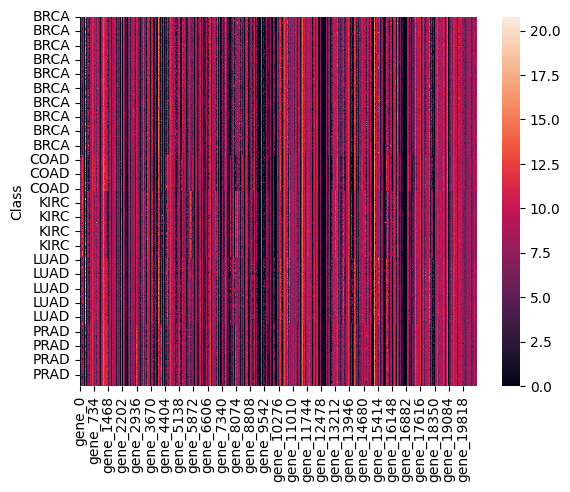

In [13]:
sns.heatmap(df)

In [14]:
# Count the number of 0.0 values in each column
zero_counts = (df == 0.0).sum()

# Get the column names to delete
col_to_del = zero_counts[zero_counts > 400].index.tolist()

# Drop the columns from the DataFrame
df.drop(columns=col_to_del, inplace=True)

# Print the resulting DataFrame
df

,gene_1,gene_2,gene_3,gene_4,gene_6,gene_7,gene_10,gene_11,gene_12,gene_18,...,gene_20520,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529
Class,,,,,,,,,,,,,,,,,,,,,
BRCA,3.801873,5.025591,6.404150,9.564754,9.997688,1.025241,0.000000,1.618568,1.843341,0.000000,...,9.055635,5.919628,8.507347,9.849333,8.184360,9.796564,11.607552,10.456272,9.949412,5.980037
BRCA,3.277330,2.629846,6.000487,9.627027,8.375748,1.029559,0.760689,1.029559,2.462759,1.029559,...,8.266145,6.152192,9.015499,10.244994,5.172335,9.788066,11.582057,11.098776,9.909158,5.494595
BRCA,1.149975,0.462576,5.861427,10.092440,5.445833,1.045932,0.000000,0.000000,2.319762,1.973758,...,8.922326,6.494526,9.549727,10.037602,6.636375,9.459339,10.109922,10.442394,9.574616,3.541862
BRCA,4.538159,3.955722,6.259862,9.103243,6.918327,1.162726,0.695459,1.023113,2.415678,0.000000,...,7.639594,7.102994,9.813018,10.629311,7.128757,10.409104,11.195225,11.169593,10.513451,6.729131
BRCA,2.599770,2.562792,7.365491,10.462155,7.922370,0.000000,0.468323,0.821302,2.383552,0.000000,...,8.596786,5.036873,8.267555,9.630254,5.531385,9.241642,11.459872,10.045882,9.091528,9.356654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PRAD,3.190172,3.520573,7.210535,9.918593,6.625520,0.353549,0.353549,0.353549,3.840745,0.000000,...,6.609199,5.981768,8.413027,9.942809,6.571789,9.900686,11.378658,10.401882,9.584258,6.867711
PRAD,3.930822,4.049578,6.732256,9.806242,6.808784,0.000000,0.000000,0.472072,2.767061,1.111966,...,7.761737,6.683977,9.104234,10.160666,4.203326,10.076268,11.021549,10.765568,10.210075,5.520705
PRAD,2.676809,3.955629,6.639035,10.301165,7.946497,0.808426,0.460166,0.460166,3.933100,0.000000,...,7.855828,6.306275,9.071972,10.136145,7.163640,10.286477,10.573922,9.523879,10.355120,3.525868


In [15]:
# Count the number of 0.0 values in each column
zero_counts = (df == 0.0).sum()
# Print the counts
zero_col = zero_counts[zero_counts > 0].index
print(zero_col)

Index(['gene_1', 'gene_2', 'gene_7', 'gene_10', 'gene_11', 'gene_12',
       'gene_18', 'gene_20', 'gene_21', 'gene_26',
       ...
       'gene_20476', 'gene_20484', 'gene_20490', 'gene_20500', 'gene_20504',
       'gene_20507', 'gene_20509', 'gene_20514', 'gene_20517', 'gene_20524'],
      dtype='object', length=5365)


##Scaling data

In [16]:
features = list(df.columns.values)
len(features)

17721

In [17]:
x = df[features].reset_index(drop=True)
y = pd.DataFrame(df.index)

In [18]:
y

,Class
0,BRCA
1,BRCA
2,BRCA
3,BRCA
4,BRCA
...,...
796,PRAD
797,PRAD
798,PRAD
799,PRAD


In [19]:
np.array(y['Class'])

array(['BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
       'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA', 'BRCA',
      

In [20]:
x_minmax = MinMaxScaler().fit_transform(x)
x_std = StandardScaler().fit_transform(x)

In [21]:
x_minmax = pd.DataFrame(x_minmax)
x_minmax.head()

,0,1,2,3,4,5,6,7,8,9,...,17711,17712,17713,17714,17715,17716,17717,17718,17719,17720
0,0.609564,0.828829,0.272422,0.386610,0.893848,0.368924,0.000000,0.205286,0.385341,0.000000,...,0.638507,0.623506,0.413136,0.445441,0.888880,0.474790,0.548659,0.705855,0.421291,0.507551
1,0.525463,0.433719,0.193585,0.407939,0.654886,0.370477,0.061880,0.130581,0.514827,0.094788,...,0.537238,0.670798,0.527919,0.594815,0.561753,0.472575,0.543200,0.860843,0.413157,0.461806
2,0.184378,0.076289,0.166426,0.567348,0.223219,0.376369,0.000000,0.000000,0.484935,0.181718,...,0.621407,0.740413,0.648592,0.516518,0.720758,0.386895,0.227975,0.702507,0.345556,0.277792
3,0.727615,0.652384,0.244242,0.228538,0.440163,0.418396,0.056574,0.129764,0.504985,0.000000,...,0.456870,0.864148,0.708065,0.739907,0.774234,0.634443,0.460368,0.877926,0.535266,0.578141
4,0.416828,0.422660,0.460175,0.693979,0.588089,0.000000,0.038097,0.104167,0.498269,0.000000,...,0.579650,0.443994,0.358971,0.362732,0.600748,0.330154,0.517037,0.606859,0.247939,0.825744


In [22]:
x_std = pd.DataFrame(x_std)
x_std.head()

,0,1,2,3,4,5,6,7,8,9,...,17711,17712,17713,17714,17715,17716,17717,17718,17719,17720
0,0.659093,1.812543,-0.498348,-0.491601,2.340472,1.033195,-0.586764,0.756256,-1.168183,-0.690400,...,0.211027,0.030908,-0.428906,-0.545902,1.401216,0.102286,-0.201023,0.518783,0.636535,0.218020
1,0.222003,-0.437119,-1.130633,-0.368585,0.876026,1.041686,0.061827,0.084463,-0.289982,-0.367956,...,-0.413362,0.342683,0.414081,0.497946,0.136319,0.086359,-0.239078,1.626154,0.565099,-0.016203
2,-1.550679,-2.472237,-1.348452,0.550803,-1.769387,1.073886,-0.586764,-1.089798,-0.492720,-0.072245,...,0.105596,0.801618,1.300326,-0.049204,0.751141,-0.529735,-2.436451,0.494864,-0.028589,-0.958385
3,1.272626,0.807910,-0.724356,-1.403278,-0.439876,1.303577,0.006209,0.077112,-0.356734,-0.690400,...,-0.908886,1.617332,1.737106,1.511866,0.957917,1.250302,-0.816481,1.748209,1.637496,0.579454
4,-0.342594,-0.500084,1.007466,1.281145,0.466673,-0.983088,-0.187455,-0.153063,-0.402280,-0.690400,...,-0.151866,-1.152517,-0.826703,-1.123884,0.287101,-0.937740,-0.421457,-0.188533,-0.885893,1.847218


##Visualize data

In [23]:
pca_minmax = PCA(n_components=2).fit_transform(x_minmax)
pca_df = pd.DataFrame(data=pca_minmax)
pca_minmax = pd.concat([pca_df, y['Class']], axis=1)
pca_minmax.head()

,0,1,Class
0,-2.586534,-3.620410,BRCA
1,0.276346,-3.652423,BRCA
2,-5.022655,-4.476995,BRCA
3,2.990573,-6.445664,BRCA
4,-6.201204,-1.279832,BRCA


In [24]:
pca_std = PCA(n_components=2).fit_transform(x_std)
pca_df = pd.DataFrame(data=pca_std)
pca_std = pd.concat([pca_df, y['Class']], axis=1)
pca_std.head()

,0,1,Class
0,-1.941322,-29.035595,BRCA
1,22.971013,-35.229974,BRCA
2,0.556637,-71.080465,BRCA
3,62.593028,-82.199301,BRCA
4,-39.366319,-3.647562,BRCA


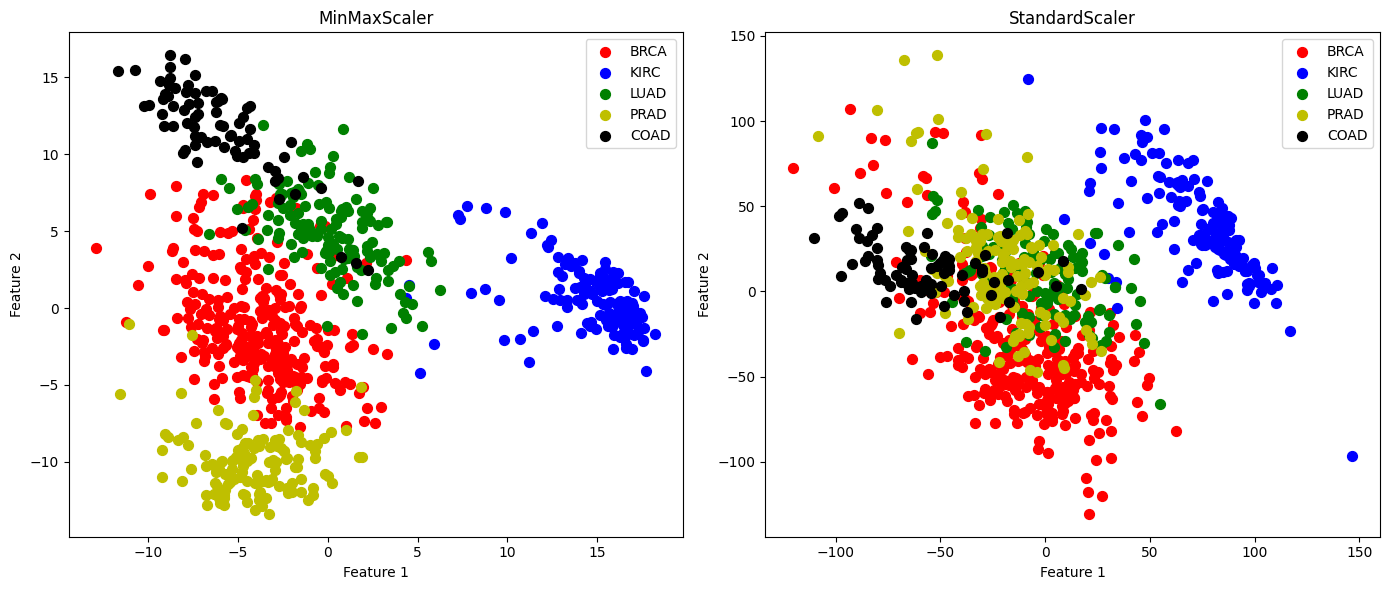

In [25]:
# Define colors for different classes
labels = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']
colors = ['r', 'b', 'g', 'y', 'black']

# Create a figure with two subplots (2 rows, 1 column)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Create scatter plots for both datasets
for i, (dataset, title) in enumerate([(pca_minmax, 'MinMaxScaler'), (pca_std, 'StandardScaler')]):
  ax = axes[i]
  ax.set_title(title)

  for label, color in zip(labels, colors):
    indices = dataset[dataset['Class'] == label]
    ax.scatter(indices.iloc[:, 0],
               indices.iloc[:, 1],
               label=label,
               c=color,
               s=50)

  ax.set_xlabel('Feature 1')
  ax.set_ylabel('Feature 2')
  ax.legend()

# Show the plots
plt.tight_layout()
plt.show()


##Splitting data

###Min Max Scaler

In [26]:
X_m = x_minmax
# Y = y['Class']

X_train1, X_temp1, y_train1, y_temp1 = train_test_split(X_m, y, test_size=0.4, random_state=42)
X_val1, X_test1, y_val1, y_test1 = train_test_split(X_temp1, y_temp1, test_size=0.5, random_state=42)

###Standard Scaler

In [27]:
X_s = x_std
# Y = y['Class']

X_train2, X_temp2, y_train2, y_temp2 = train_test_split(X_s, y, test_size=0.4, random_state=42)
X_val2, X_test2, y_val2, y_test2 = train_test_split(X_temp2, y_temp2, test_size=0.5, random_state=42)

###Without scaler

In [28]:
X = x
# Y = y['Class']

X_train3, X_temp3, y_train3, y_temp3 = train_test_split(X, y, test_size=0.4, random_state=42)
X_val3, X_test3, y_val3, y_test3 = train_test_split(X_temp3, y_temp3, test_size=0.5, random_state=42)

##One-hot encoding the labels

###Min Max Scaler

In [29]:
# Create a label encoder and fit it to your class labels
labels = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']
label_enc = LabelEncoder().fit(labels)

# Convert original labels to integers
y_train1_enc = label_enc.transform(np.array(y_train1).ravel())
y_test1_enc = label_enc.transform(np.array(y_test1).ravel())
y_val1_enc = label_enc.transform(np.array(y_val1).ravel())

# One-hot encode the integer labels
y_train1_onehot = to_categorical(y_train1_enc, num_classes=5)
y_test1_onehot = to_categorical(y_test1_enc, num_classes=5)
y_val1_onehot = to_categorical(y_val1_enc, num_classes=5)

### Standard Scaler

In [30]:
# Create a label encoder and fit it to your class labels
labels = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']
label_enc = LabelEncoder().fit(labels)

# Convert original labels to integers
y_train2_enc = label_enc.transform(np.array(y_train2).ravel())
y_test2_enc = label_enc.transform(np.array(y_test2).ravel())
y_val2_enc = label_enc.transform(np.array(y_val2).ravel())

# One-hot encode the integer labels
y_train2_onehot = to_categorical(y_train2_enc, num_classes=5)
y_test2_onehot = to_categorical(y_test2_enc, num_classes=5)
y_val2_onehot = to_categorical(y_val2_enc, num_classes=5)

###Without scalar

In [31]:
# Create a label encoder and fit it to your class labels
labels = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']
label_enc = LabelEncoder().fit(labels)

# Convert original labels to integers
y_train3_enc = label_enc.transform(np.array(y_train3).ravel())
y_test3_enc = label_enc.transform(np.array(y_test3).ravel())
y_val3_enc = label_enc.transform(np.array(y_val3).ravel())

# One-hot encode the integer labels
y_train3_onehot = to_categorical(y_train3_enc, num_classes=5)
y_test3_onehot = to_categorical(y_test3_enc, num_classes=5)
y_val3_onehot = to_categorical(y_val3_enc, num_classes=5)

##Model

###Artificial Neural Network (ANN)

In [32]:
model = tf.keras.models.Sequential([
    layers.Flatten(input_shape=(17721,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 17721)             0         
                                                                 
 dense (Dense)               (None, 128)               2268416   
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 5)                 165       
                                                                 
Total params: 2278917 (8.69 MB)
Trainable params: 2278917 (8.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##Training data

###Min Max Scaler Data

In [33]:
X_train1.shape

(480, 17721)

In [34]:
y_train1.shape

(480, 1)

In [35]:
model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train1, y_train1_onehot,
                    epochs=10,
                    steps_per_epoch=20,
                    validation_data = (X_val1, y_val1_onehot))

Epoch 1/10
20/20 [==============================] - 2s 52ms/step - loss: 1.6173 - accuracy: 0.5063 - val_loss: 0.5674 - val_accuracy: 0.8250
Epoch 2/10
20/20 [==============================] - 1s 35ms/step - loss: 0.3851 - accuracy: 0.8938 - val_loss: 0.1552 - val_accuracy: 0.9812
Epoch 3/10
20/20 [==============================] - 1s 58ms/step - loss: 0.0891 - accuracy: 0.9917 - val_loss: 0.0703 - val_accuracy: 0.9875
Epoch 4/10
20/20 [==============================] - 1s 61ms/step - loss: 0.0353 - accuracy: 0.9958 - val_loss: 0.0241 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 1s 66ms/step - loss: 0.0237 - accuracy: 1.0000 - val_loss: 0.0196 - val_accuracy: 0.9937
Epoch 6/10
20/20 [==============================] - 1s 71ms/step - loss: 0.0151 - accuracy: 0.9979 - val_loss: 0.0180 - val_accuracy: 0.9937
Epoch 7/10
20/20 [==============================] - 2s 80ms/step - loss: 0.0099 - accuracy: 1.0000 - val_loss: 0.0115 - val_accuracy: 1.0000
Epoch 8/10
20

####Evaluation on test data

In [36]:
# Step 1: Make Predictions
y_pred1 = model.predict(X_test1)

# Step 2: Convert predictions to class labels (if needed)
y_pred_class = np.argmax(y_pred1, axis=1)

# Convert one-hot encoded format to class indices
y_true1 = np.argmax(y_test1_onehot, axis=1)

# Step 3: Calculate Accuracy
accuracy = accuracy_score(y_true1, y_pred_class)
print(f'Accuracy: {accuracy:.2f}')

# # Step 4: Calculate Confusion Matrix
# conf_matrix = confusion_matrix(y_true1, y_pred_class)
# print('Confusion Matrix:')
# print(conf_matrix)

# Step 5: Calculate Precision, Recall, and F1 Score
precision = precision_score(y_true1, y_pred_class, average='weighted')
recall = recall_score(y_true1, y_pred_class, average='weighted')
f1 = f1_score(y_true1, y_pred_class, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# Step 6: Calculate Loss (if not already available)
loss = model.evaluate(X_test1, y_test1_onehot, verbose=0)
print(f'Loss: {loss[0]:.2f}')


6/6 [==============================] - 0s 6ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Loss: 0.01


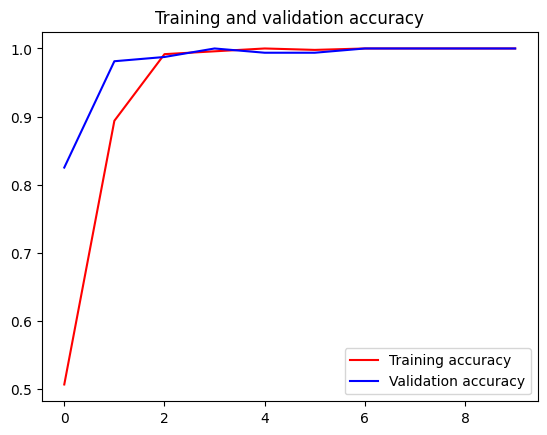

<Figure size 640x480 with 0 Axes>

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### Standard Scaler

In [38]:
model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train2, y_train2_onehot,
                    epochs=10,
                    steps_per_epoch=20,
                    validation_data = (X_test2, y_test2_onehot))

Epoch 1/10
20/20 [==============================] - 2s 49ms/step - loss: 0.2083 - accuracy: 0.9563 - val_loss: 0.0235 - val_accuracy: 0.9876
Epoch 2/10
20/20 [==============================] - 1s 37ms/step - loss: 0.0421 - accuracy: 0.9937 - val_loss: 9.9613e-04 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 1s 37ms/step - loss: 0.0273 - accuracy: 0.9958 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 1s 31ms/step - loss: 0.0088 - accuracy: 0.9958 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 1s 28ms/step - loss: 0.0353 - accuracy: 0.9958 - val_loss: 0.0274 - val_accuracy: 0.9876
Epoch 6/10
20/20 [==============================] - 1s 36ms/step - loss: 0.0039 - accuracy: 0.9979 - val_loss: 0.0194 - val_accuracy: 0.9938
Epoch 7/10
20/20 [==============================] - 1s 33ms/step - loss: 0.0049 - accuracy: 0.9979 - val_loss: 0.0250 - val_accuracy: 0.9938
Epoch 8/1

####Evaluation on test data

In [39]:
# Step 1: Make Predictions
y_pred2 = model.predict(X_test2)

# Step 2: Convert predictions to class labels (if needed)
y_pred_class = np.argmax(y_pred2, axis=1)

# Convert one-hot encoded format to class indices
y_true2 = np.argmax(y_test2_onehot, axis=1)

# Step 3: Calculate Accuracy
accuracy = accuracy_score(y_true2, y_pred_class)
print(f'Accuracy: {accuracy:.2f}')

# # Step 4: Calculate Confusion Matrix
# conf_matrix = confusion_matrix(y_true1, y_pred_class)
# print('Confusion Matrix:')
# print(conf_matrix)

# Step 5: Calculate Precision, Recall, and F1 Score
precision = precision_score(y_true2, y_pred_class, average='weighted')
recall = recall_score(y_true2, y_pred_class, average='weighted')
f1 = f1_score(y_true2, y_pred_class, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# Step 6: Calculate Loss (if not already available)
loss = model.evaluate(X_test2, y_test2_onehot, verbose=0)
print(f'Loss: {loss[0]:.2f}')


6/6 [==============================] - 0s 6ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Loss: 0.01


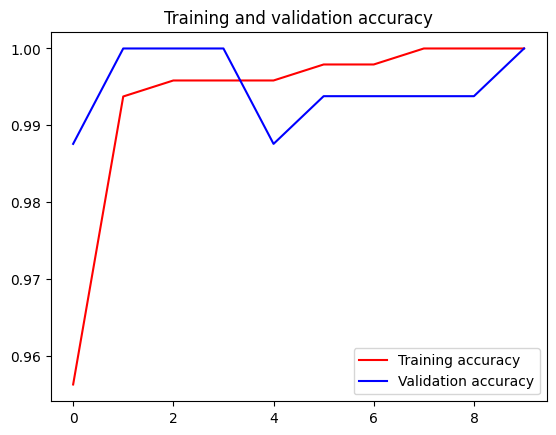

<Figure size 640x480 with 0 Axes>

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

###Without scaler

In [41]:
model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train3, y_train3_onehot,
                    epochs=10,
                    steps_per_epoch=20,
                    validation_data = (X_test3, y_test3_onehot))

Epoch 1/10
20/20 [==============================] - 2s 43ms/step - loss: 14.1678 - accuracy: 0.7688 - val_loss: 0.7104 - val_accuracy: 0.9379
Epoch 2/10
20/20 [==============================] - 1s 37ms/step - loss: 0.2623 - accuracy: 0.9771 - val_loss: 0.1600 - val_accuracy: 0.9876
Epoch 3/10
20/20 [==============================] - 1s 38ms/step - loss: 0.0612 - accuracy: 0.9896 - val_loss: 0.1140 - val_accuracy: 0.9876
Epoch 4/10
20/20 [==============================] - 1s 31ms/step - loss: 0.0019 - accuracy: 0.9979 - val_loss: 2.0732e-08 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 1s 31ms/step - loss: 0.0203 - accuracy: 0.9979 - val_loss: 0.0971 - val_accuracy: 0.9938
Epoch 6/10
20/20 [==============================] - 1s 37ms/step - loss: 0.0097 - accuracy: 0.9979 - val_loss: 5.9234e-09 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 1s 36ms/step - loss: 0.1590 - accuracy: 0.9854 - val_loss: 0.2054 - val_accuracy: 0.9876
Epoc

####Evaluation on test data

In [42]:
# Step 1: Make Predictions
y_pred3 = model.predict(X_test3)

# Step 2: Convert predictions to class labels (if needed)
y_pred_class = np.argmax(y_pred3, axis=1)

# Convert one-hot encoded format to class indices
y_true3 = np.argmax(y_test3_onehot, axis=1)

# Step 3: Calculate Accuracy
accuracy = accuracy_score(y_true3, y_pred_class)
print(f'Accuracy: {accuracy:.2f}')

# # Step 4: Calculate Confusion Matrix
# conf_matrix = confusion_matrix(y_true1, y_pred_class)
# print('Confusion Matrix:')
# print(conf_matrix)

# Step 5: Calculate Precision, Recall, and F1 Score
precision = precision_score(y_true3, y_pred_class, average='weighted')
recall = recall_score(y_true3, y_pred_class, average='weighted')
f1 = f1_score(y_true3, y_pred_class, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')

# Step 6: Calculate Loss (if not already available)
loss = model.evaluate(X_test3, y_test3_onehot, verbose=0)
print(f'Loss: {loss[0]:.2f}')


6/6 [==============================] - 0s 16ms/step
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-Score: 1.00
Loss: 0.00


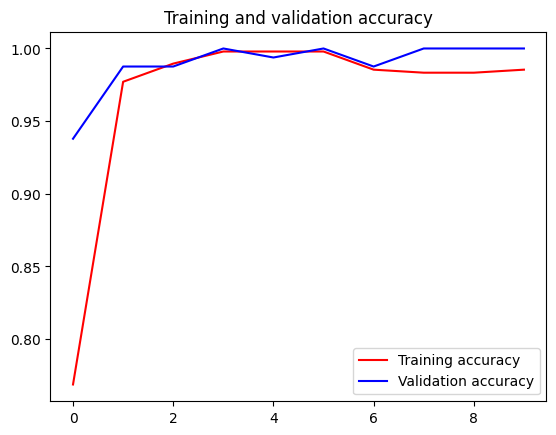

<Figure size 640x480 with 0 Axes>

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

###Using KFold

#### Min Max Scaler

In [44]:
Y = y['Class']

# Create a label encoder and fit it to your class labels
labels = ['BRCA', 'KIRC', 'LUAD', 'PRAD', 'COAD']
label_enc = LabelEncoder().fit(labels)

# Convert original labels to integeres
y_enc = label_enc.transform(Y)
y_onehot = to_categorical(y_enc, num_classes=5)

In [45]:
y_onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [46]:
# Initialize KFold with the desired number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the results
acc_scores = []
x_minmax = np.array(x_minmax)
y = np.array(y_onehot)

# Loop over the folds
for train_index, test_index in kf.split(x_minmax):
  X_train1, X_test1 = x_minmax[train_index], x_minmax[test_index]
  y_train1, y_test1 = y[train_index], y[test_index]

  # Train the model on the training data
  history = model.fit(X_train1, y_train1, epochs=10, verbose=1)

  # Evaluate the model on the test data
  _, accuracy = model.evaluate(X_test1, y_test1, verbose=1)
  acc_scores.append(accuracy)

# Calculate and print the mean accuracy and standard deviation
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

print(f'Mean Acc: {mean_acc:.2f}')
print(f'Standard Deviation: {std_acc:.2f}')

Epoch 1/10
20/20 [==============================] - 1s 28ms/step - loss: 0.0369 - accuracy: 0.9969
Epoch 2/10
20/20 [==============================] - 1s 28ms/step - loss: 0.0046 - accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 1s 34ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 1s 32ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 1s 34ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 1s 33ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 1s 33ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 8/10
20/20 [==============================] - 1s 35ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 9/10
20/20 [==============================] - 1s 47ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 10/10
6/6 [==============================] - 0s 24ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 1/10


#### Standard Scaler

In [47]:
# Initialize KFold with the desired number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the results
acc_scores = []
x_std = np.array(x_std)
y = np.array(y_onehot)

# Loop over the folds
for train_index, test_index in kf.split(x_std):
  X_train2, X_test2 = x_std[train_index], x_std[test_index]
  y_train2, y_test2 = y[train_index], y[test_index]

  # Train the model on the training data
  history = model.fit(X_train2, y_train2, epochs=10,
            steps_per_epoch=20,
            verbose=1)

  # Evaluate the model on the test data
  _, accuracy = model.evaluate(X_test2, y_test2, verbose=1)
  acc_scores.append(accuracy)

# Calculate and print the mean accuracy and standard deviation
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

print(f'Mean Acc: {mean_acc:.2f}')
print(f'Standard Deviation: {std_acc:.2f}')

Epoch 1/10
20/20 [==============================] - 1s 26ms/step - loss: 0.1411 - accuracy: 0.9969
Epoch 2/10
20/20 [==============================] - 1s 32ms/step - loss: 0.6176 - accuracy: 0.9688
Epoch 3/10
20/20 [==============================] - 1s 33ms/step - loss: 0.1492 - accuracy: 0.9937
Epoch 4/10
20/20 [==============================] - 1s 33ms/step - loss: 0.2792 - accuracy: 0.9891
Epoch 5/10
20/20 [==============================] - 1s 34ms/step - loss: 0.0160 - accuracy: 0.9969
Epoch 6/10
20/20 [==============================] - 1s 34ms/step - loss: 0.0127 - accuracy: 0.9984
Epoch 7/10
20/20 [==============================] - 1s 34ms/step - loss: 0.0942 - accuracy: 0.9984
Epoch 8/10
20/20 [==============================] - 1s 30ms/step - loss: 1.3411e-08 - accuracy: 1.0000
Epoch 9/10
20/20 [==============================] - 1s 27ms/step - loss: 0.5046 - accuracy: 0.9922
Epoch 10/10
6/6 [==============================] - 0s 6ms/step - loss: 2.3879 - accuracy: 0.9938
Epoch 1/

#### Without scaler

In [48]:
# Initialize KFold with the desired number of splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the results
acc_scores = []
x = np.array(x)
y = np.array(y_onehot)

# Loop over the folds
for train_index, test_index in kf.split(x):
  X_train3, X_test3 = x[train_index], x[test_index]
  y_train3, y_test3 = y[train_index], y[test_index]

  # Train the model on the training data
  history = model.fit(X_train3, y_train3, epochs=10, batch_size=32,
            steps_per_epoch=20,
            verbose=1)

  # Evaluate the model on the test data
  _, accuracy = model.evaluate(X_test3, y_test3, verbose=1)
  acc_scores.append(accuracy)

# Calculate and print the mean accuracy and standard deviation
mean_acc = np.mean(acc_scores)
std_acc = np.std(acc_scores)

print(f'Mean Acc: {mean_acc:.2f}')
print(f'Standard Deviation: {std_acc:.2f}')

Epoch 1/10
20/20 [==============================] - 1s 36ms/step - loss: 100.8904 - accuracy: 0.4766
Epoch 2/10
20/20 [==============================] - 1s 40ms/step - loss: 5.6851 - accuracy: 0.7719
Epoch 3/10
20/20 [==============================] - 1s 34ms/step - loss: 1.2429 - accuracy: 0.9219
Epoch 4/10
20/20 [==============================] - 1s 33ms/step - loss: 0.3552 - accuracy: 0.9641
Epoch 5/10
20/20 [==============================] - 1s 34ms/step - loss: 0.0907 - accuracy: 0.9937
Epoch 6/10
20/20 [==============================] - 1s 33ms/step - loss: 0.0109 - accuracy: 0.9984
Epoch 7/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0677 - accuracy: 0.9937
Epoch 8/10
20/20 [==============================] - 1s 28ms/step - loss: 0.0120 - accuracy: 0.9969
Epoch 9/10
20/20 [==============================] - 1s 33ms/step - loss: 0.0251 - accuracy: 0.9969
Epoch 10/10
6/6 [==============================] - 0s 6ms/step - loss: 1.2653e-06 - accuracy: 1.0000
Epoch 

##Save the model

In [ ]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Save the model weights to an HDF5 file
model.save_weights("model_weights.h5")